# Energies and logits, linear

Results referenced in 25b_Section_2_research.ipynb.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

#import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets

#import utils_07

Fontconfig warning: ignoring UTF-8: not a valid region tag


Interpretation: less confidence range!

Logits ~ Energy

In [2]:
from itertools import permutations


task_types = (
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.ONE_VS_NINE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
)

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_Linear_ML/")
)

def task_generator(task_types=task_types, loader=loader):
    """
    Generate tasks for which to compute attributions.
    """
    # Generate 1v1
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:            
            task = datasets.ClassificationTask(
                task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
                ag_pos=ag_1,
                ag_neg=ag_2,
                seed_id=seed_id,
                split_id=split_id,
            )
            yield task
    
    # Generate the rest: 1v9, high vs 95low, high vs looser
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1 in config.ANTIGENS:
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    continue
                
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag_1,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
                yield task


def get_miniabsolut_dataframes(task, load_energy_contributions=False):
    """Load the dataframes based on MiniAbsolut, from task
    These dataframes contain extra info, such as binding energies.
    """
    if task.split_id == 42:
        miniabsolut_path = Path("../data/MiniAbsolut")
    elif task.split_id in [0, 1, 2, 3, 4]:
        miniabsolut_path = Path(f"../data/MiniAbsolut_Splits/MiniAbsolut_Seed{task.split_id}")
    
    ag_pos_dir = miniabsolut_path / task.ag_pos
    if load_energy_contributions:
        ag_pos_dir = ag_pos_dir / "energy_contributions"
        suffix = "_absolut_energy_contributions"
        header = 1
    else:
        suffix = ""
        header = 0
    
    df_pos = pd.read_csv(ag_pos_dir / f"high_test_5000{suffix}.tsv", sep="\t", header=header)
    df_pos["class"] = "positive"

    if task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
        df_neg = pd.read_csv(ag_pos_dir / f"95low_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
        df_neg = pd.read_csv(ag_pos_dir / f"looserX_test_5000{suffix}.tsv", sep='\t', header=header)
        df_neg["class"] = "negative"
    elif task.task_type in (datasets.ClassificationTaskType.ONE_VS_ONE, datasets.ClassificationTaskType.ONE_VS_NINE):
        # raise ValueError("Not implemented.")
        df_neg = pd.DataFrame()
    
    df = pd.concat([df_pos, df_neg], axis=0)
    
    return df

In [3]:
logit_energy_corr_path = "../data/Frozen_MiniAbsolut_Linear_ML/07e_LogitEnergyCorrelations.tsv"
force_run = False
skip_errors_logits = True

if Path(logit_energy_corr_path).exists() and not force_run:
    df_logits = pd.read_csv(logit_energy_corr_path, sep="\t")
else:

    records = []
    for task in task_generator():
        
        # Method extracted in utils_07.py
        #  To be refactored.

        if skip_errors_logits:
            try:
                task = loader.load(task, attributions_toload="v0.1.2-3")
            except:
                continue
        else:
            task = loader.load(task, attributions_toload="v0.1.2-3")

        # Get energies
        df = get_miniabsolut_dataframes(task)

        # Add logits to df
        df_attr = pd.DataFrame.from_records(task.attributions)
        df = pd.merge(df, df_attr[["slide", "logits"]], left_on="Slide", right_on="slide", how='left')

        # Compute correlation and p-val with scipy for all and positive class
        r, p = pearsonr(df["logits"], df["Energy"])
        r_pos, p_pos = pearsonr(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"])

        # Compute slope for all and positive class
        slope, intercept = np.polyfit(df["logits"], df["Energy"], 1)
        slope_pos, intercept_pos = np.polyfit(df[df["class"] == "positive"]["logits"], df[df["class"] == "positive"]["Energy"], 1)
        
        records.append({
            "task_type": task.task_type.to_str(),
            "ag_pos": task.ag_pos,
            "ag_neg": task.ag_neg,
            "seed_id": task.seed_id,
            "split_id": task.split_id,
            "r": r,
            "p": p,
            "r2": r**2,
            "r_pos": r_pos,
            "r_pos2": r_pos**2,
            "p_pos": p_pos,
            "slope": slope,
            "intercept": intercept,
            "slope_pos": slope_pos,
            "intercept_pos": intercept_pos,
            "logits_mean": df["logits"].mean(),
            "logits_std": df["logits"].std(),
            "Energy_mean": df["Energy"].mean(),
            "Energy_std": df["Energy"].std(),
            "logits_pos_mean": df[df["class"] == "positive"]["logits"].mean(),
            "logits_pos_std": df[df["class"] == "positive"]["logits"].std(),
            "Energy_pos_mean": df[df["class"] == "positive"]["Energy"].mean(),
            "Energy_pos_std": df[df["class"] == "positive"]["Energy"].std(),
            "logits_neg_mean": df[df["class"] == "negative"]["logits"].mean(),
            "logits_neg_std": df[df["class"] == "negative"]["logits"].std(),
            "Energy_neg_mean": df[df["class"] == "negative"]["Energy"].mean(),
            "Energy_neg_std": df[df["class"] == "negative"]["Energy"].std(),
        })

    df_logits = pd.DataFrame.from_records(records)
    df_logits.to_csv(logit_energy_corr_path, index=False, sep='\t')

In [5]:
df_logits

,task_type,ag_pos,ag_neg,seed_id,split_id,r,p,r2,r_pos,r_pos2,...,Energy_mean,Energy_std,logits_pos_mean,logits_pos_std,Energy_pos_mean,Energy_pos_std,logits_neg_mean,logits_neg_std,Energy_neg_mean,Energy_neg_std
0,1v1,3VRL,1NSN,0,42,-0.477576,2.614045e-283,0.228079,-0.477576,0.228079,...,-98.309468,1.678374,5.568703,2.588364,-98.309468,1.678374,NaN,NaN,NaN,NaN
1,1v1,3VRL,1NSN,1,42,-0.477063,1.278195e-282,0.227589,-0.477063,0.227589,...,-98.309468,1.678374,5.574727,2.591647,-98.309468,1.678374,NaN,NaN,NaN,NaN
2,1v1,3VRL,1NSN,2,42,-0.477060,1.290048e-282,0.227586,-0.477060,0.227586,...,-98.309468,1.678374,5.541178,2.589019,-98.309468,1.678374,NaN,NaN,NaN,NaN
3,1v1,3VRL,1NSN,3,42,-0.476834,2.595039e-282,0.227370,-0.476834,0.227370,...,-98.309468,1.678374,5.552056,2.590842,-98.309468,1.678374,NaN,NaN,NaN,NaN
4,1v1,3VRL,3RAJ,0,42,-0.331137,3.032178e-128,0.109652,-0.331137,0.109652,...,-98.309468,1.678374,3.267472,1.931710,-98.309468,1.678374,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,high_vs_95low,1OB1,auto,0,3,-0.929630,0.000000e+00,0.864211,-0.569297,0.324099,...,-86.133761,9.121032,4.420819,2.546388,-94.427450,1.689579,-7.276998,4.077146,-77.840072,5.094146
576,high_vs_looser,1OB1,auto,0,3,-0.656514,0.000000e+00,0.431010,-0.573737,0.329174,...,-92.088967,2.761174,0.937993,1.242283,-94.427450,1.689579,-0.945024,1.564046,-89.750485,1.206573
577,1v9,1OB1,auto,0,4,-0.131278,1.154419e-20,0.017234,-0.131278,0.017234,...,-94.416142,1.699552,1.957198,1.756623,-94.416142,1.699552,NaN,NaN,NaN,NaN
578,high_vs_95low,1OB1,auto,0,4,-0.925713,0.000000e+00,0.856945,-0.570353,0.325302,...,-86.183371,9.043904,4.383388,2.516943,-94.416142,1.699552,-7.005718,4.012844,-77.950599,5.012796


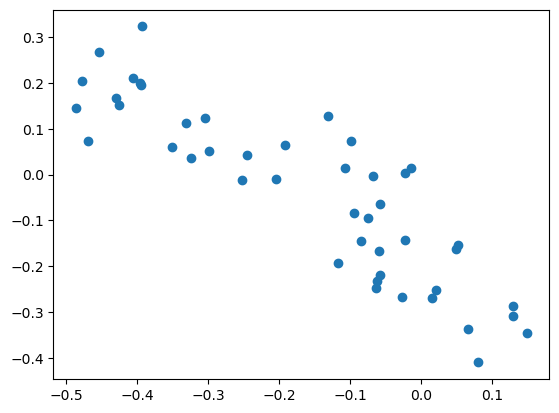

In [6]:
## As for per residue energy correlations, let's check for 
##  symmetry or antisymmetry.

## There is a pattern for 1v1 when one looks at the correlation between forward and backwards, there is antisymmetry!

from itertools import combinations

df_logits_1v1 = df_logits.query("task_type == '1v1'").copy()
ags = df_logits_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_logits_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").r_pos.median()
    r_bwd = df_logits_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").r_pos.median()
    res.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
    })

plt.plot([r["r_fwd"] for r in res], [r["r_bwd"] for r in res], 'o')

In [7]:
## FLAG
## Reduce the 1v1 to a single value by min of abs value!

df_logits_1v1 = df_logits.query("task_type == '1v1'").copy()
ags = df_logits_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_logits_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").r_pos.median()
    r_bwd = df_logits_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").r_pos.median()
    res.append({
        "ag_pos": ag_1,
        "ag_neg": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
        # Adapted
        "task_type": "1v1_adapted",
        "r_pos": -max([abs(r_fwd), abs(r_bwd)]),
    })

df_logits_1v1_adapted = pd.DataFrame.from_records(res)
df_logits = pd.concat([df_logits, df_logits_1v1_adapted], axis=0)

In [8]:
df_logits.groupby(["task_type"]).agg({"r_pos": ["min", "median", "max"]})

r_pos                    
                     min    median       max
task_type                                   
1v1            -0.486351 -0.083743  0.323513
1v1_adapted    -0.485745 -0.252736 -0.013754
1v9            -0.641685 -0.128046  0.039935
high_vs_95low  -0.741433 -0.597392 -0.359074
high_vs_looser -0.772297 -0.577920 -0.274956

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_33359/2274692948.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


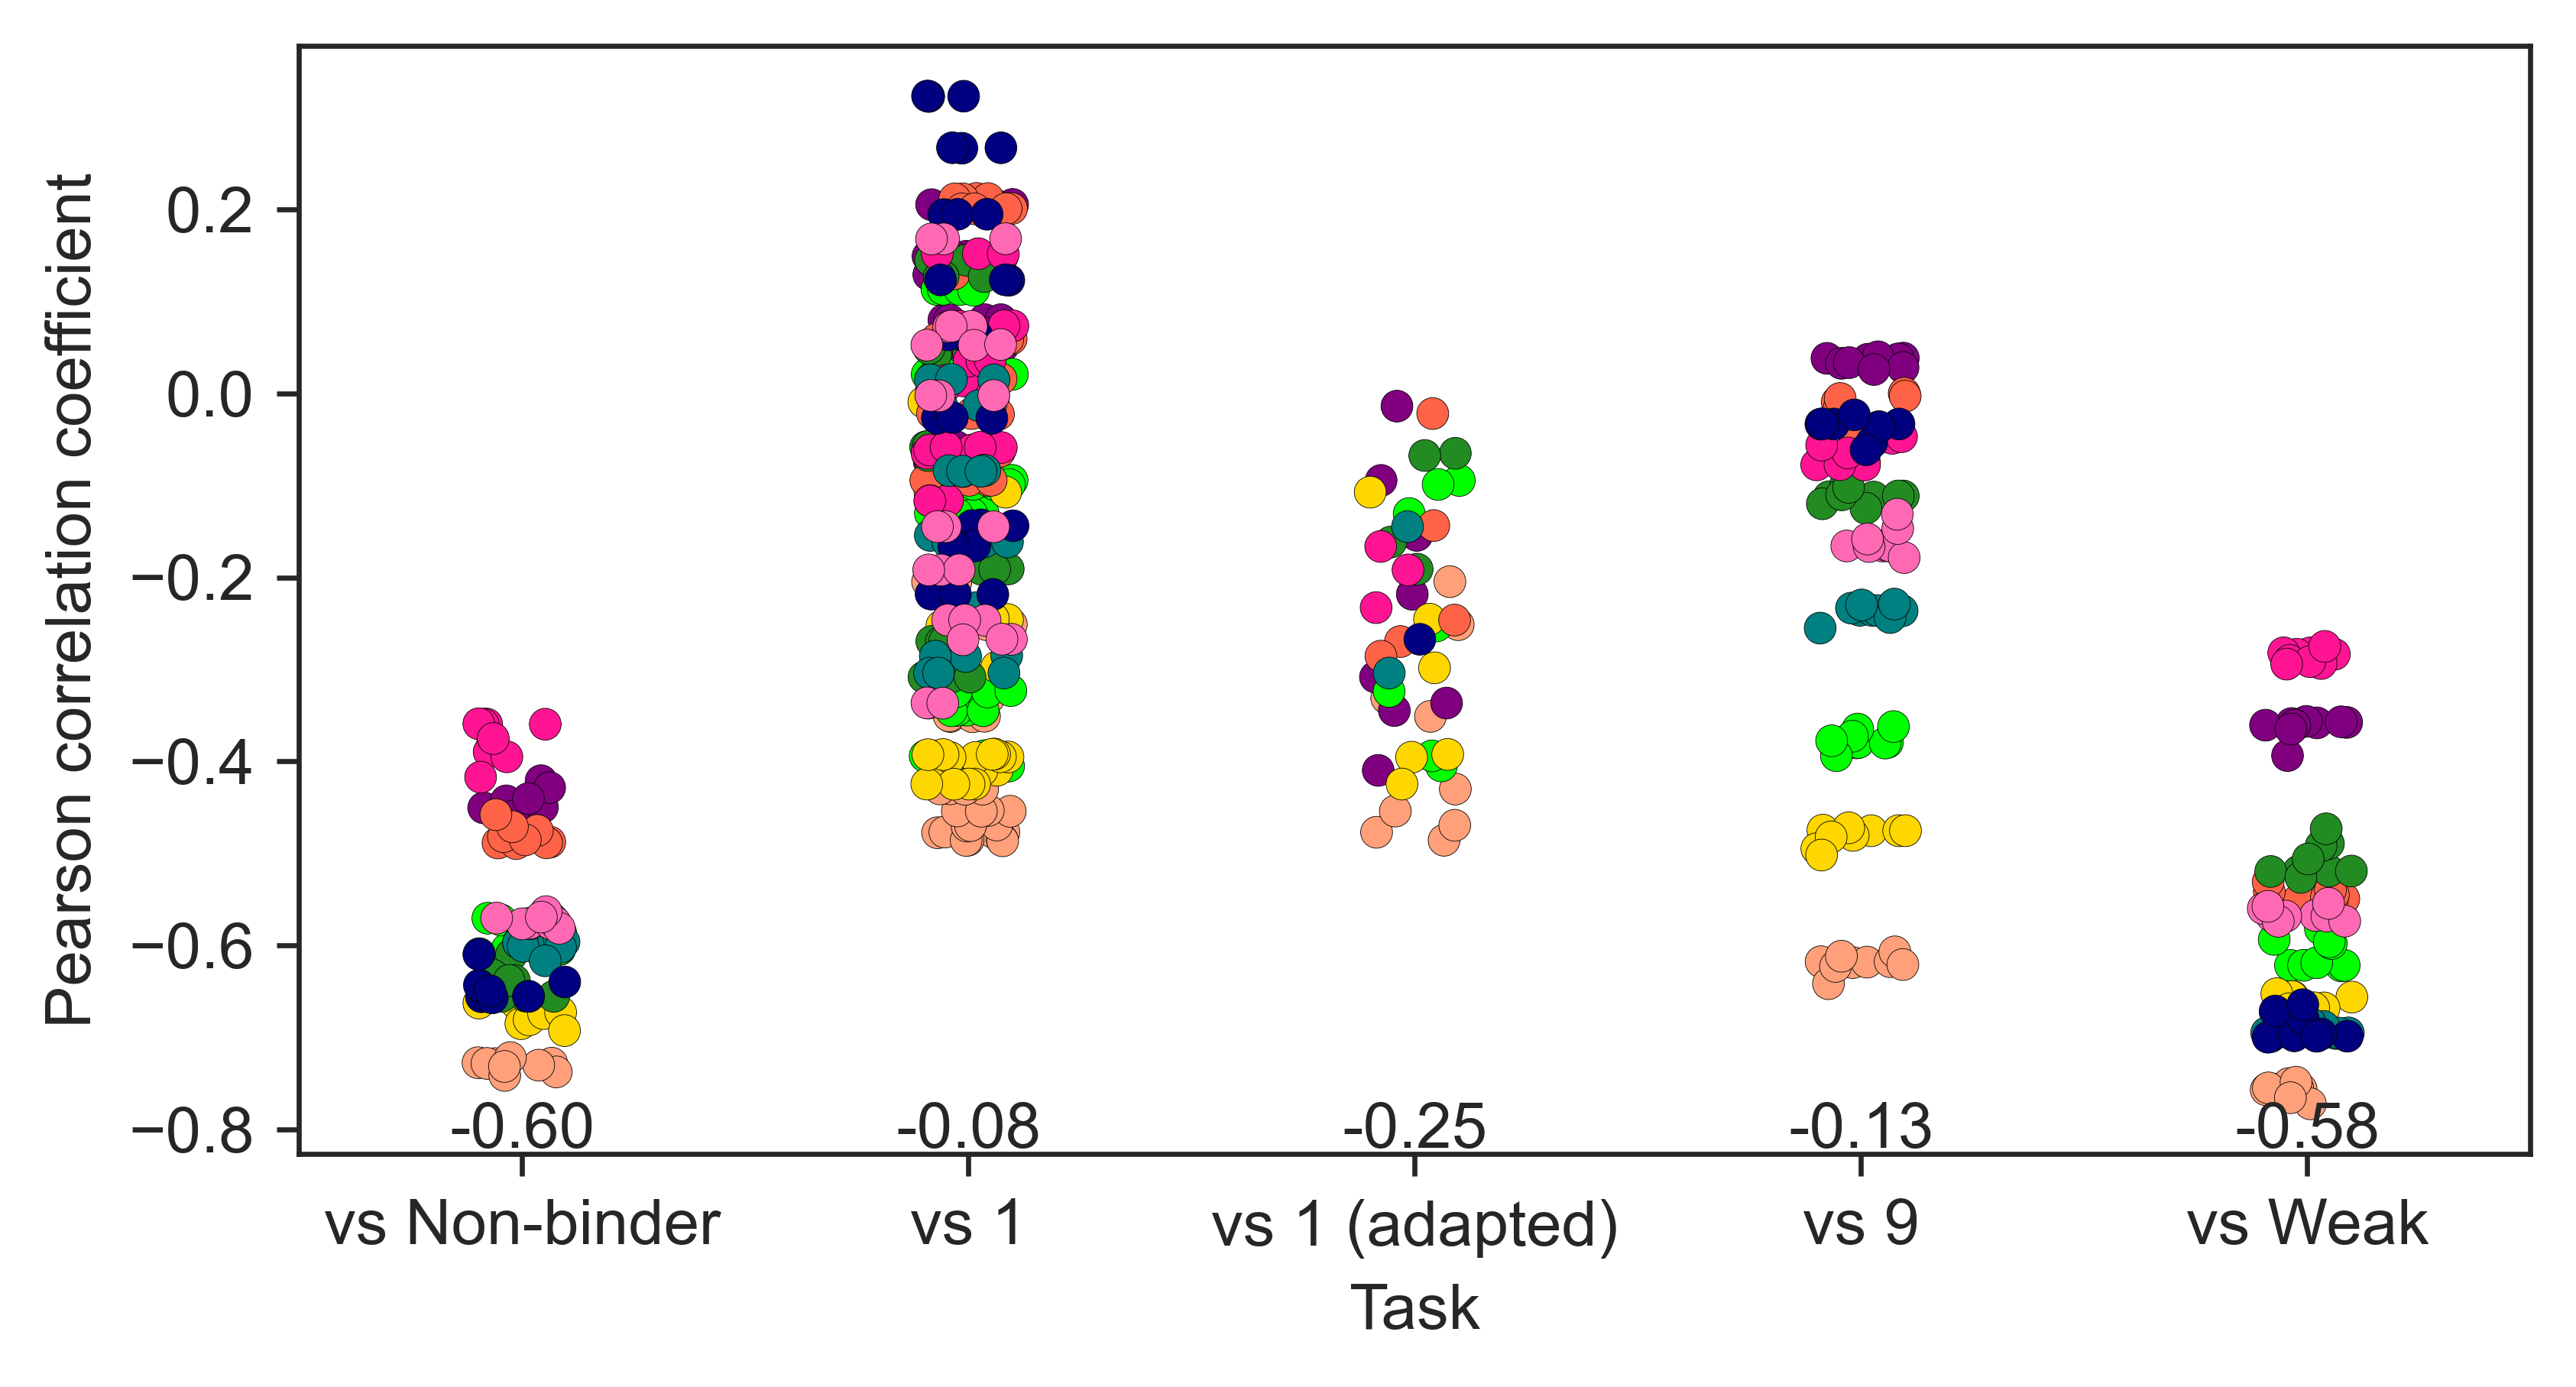

In [10]:
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

palette = {'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'}

task_order = ["high_vs_95low", "1v1", "1v1_adapted", "1v9", "high_vs_looser"]
sns.stripplot(
    data=df_logits, 
    x="task_type", 
    y="r_pos",
    hue="ag_pos", 
    ax=ax, 
    # cmap=visualisations.PlotParams.cmap_antigens,
    palette=palette,
    order=task_order,
    edgecolor = 'black',
    linewidth =  0.1
)

# Display no legend
ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_logits.groupby(["task_type"]).agg({"r_pos": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.82,
        f"{row['r_pos']:.2f}",
        # Center center
        horizontalalignment='center',
    )


ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")

# Save fig as .svg
fig.savefig(
    "./figures/S2E_Linear_Logit-Energy.svg",
    bbox_inches='tight',
    dpi=600,
    transparent=True,
)

In [11]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_logits.query("task_type == 'high_vs_95low'")["r_pos"],
    df_logits.query("task_type == '1v1'")["r_pos"],
    df_logits.query("task_type == '1v9'")["r_pos"],
    df_logits.query("task_type == 'high_vs_looser'")["r_pos"],
)

F_onewayResult(statistic=247.03896122394033, pvalue=5.108602409898101e-103)

In [13]:
# Logits pos mean and logits ~ energy correlation rank relation
# Low
df_logits.groupby(["task_type", "ag_pos"])[["logits_pos_mean", "r_pos"]].mean().corr()

,logits_pos_mean,r_pos
logits_pos_mean,1.000000,0.064359
r_pos,0.064359,1.000000


Energy contributions ~ Attributions correlations

In [14]:
energy_contributions_path = "../data/Frozen_MiniAbsolut_Linear_ML/07e_EnergyContributions.tsv"
# energy_contributions_path = "../data/Frozen_MiniAbsolut_Linear_ML/07e_EnergyContributions_1v1.tsv"
force_run_contrib = False
skip_errors_contrib = True

if Path(energy_contributions_path).exists() and not force_run_contrib:
    df_attrib = pd.read_csv(energy_contributions_path, sep="\t")
else:

    records = []
    # for task in task_generator():
    for task in task_generator():
        
        if skip_errors_contrib:
            try:
                stats = load_energy_contributions_from_task_linear_version(task)
            except:
                continue
        else:
            stats = load_energy_contributions_from_task_linear_version(task)
        
        records.append(stats)
     
    df_attrib = pd.DataFrame.from_records(records)
    df_attrib.to_csv(energy_contributions_path, index=False, sep='\t')

In [15]:
df_attrib.shape

(541, 23)

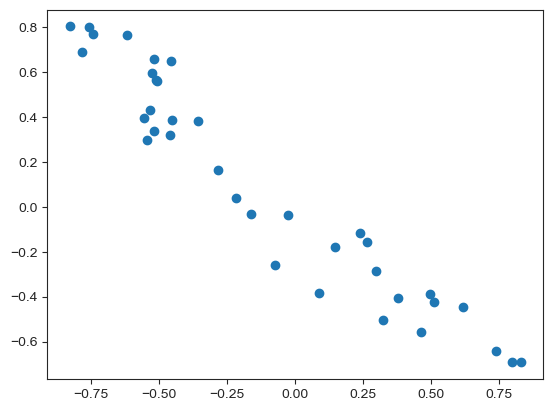

In [16]:
## There is a pattern for 1v1 when one looks at the correlation between forward and backwards, there is antisymmetry!

from itertools import combinations

df_attrib_1v1 = df_attrib.query("task_type == '1v1'").copy()
ags = df_attrib_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_attrib_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").mean_pos_total.median()
    r_bwd = df_attrib_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").mean_pos_total.median()
    res.append({
        "ag_1": ag_1,
        "ag_2": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
    })

plt.plot([r["r_fwd"] for r in res], [r["r_bwd"] for r in res], 'o')

In [17]:
## FLAG
## Reduce the 1v1 to a single value by min of abs value!

df_attrib_1v1 = df_attrib.query("task_type == '1v1'").copy()
ags = df_attrib_1v1.ag_pos.unique().tolist()

res = []
for ag_1, ag_2 in combinations(ags, r=2):
    r_fwd = df_attrib_1v1.query("ag_pos == @ag_1 and ag_neg == @ag_2").mean_pos_total.median()
    r_bwd = df_attrib_1v1.query("ag_pos == @ag_2 and ag_neg == @ag_1").mean_pos_total.median()
    res.append({
        "ag_pos": ag_1,
        "ag_neg": ag_2,
        "r_fwd": r_fwd,
        "r_bwd": r_bwd,
        # Adapted
        "task_type": "1v1_adapted",
        "mean_pos_total": -min([abs(r_fwd), abs(r_bwd)]),
    })

df_attrib_1v1_adapted = pd.DataFrame.from_records(res)
df_attrib = pd.concat([df_attrib, df_attrib_1v1_adapted], axis=0)

/var/folders/ww/bptfq9n12_jbyy78qcjp7s4c0000gn/T/ipykernel_33359/2069872814.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))


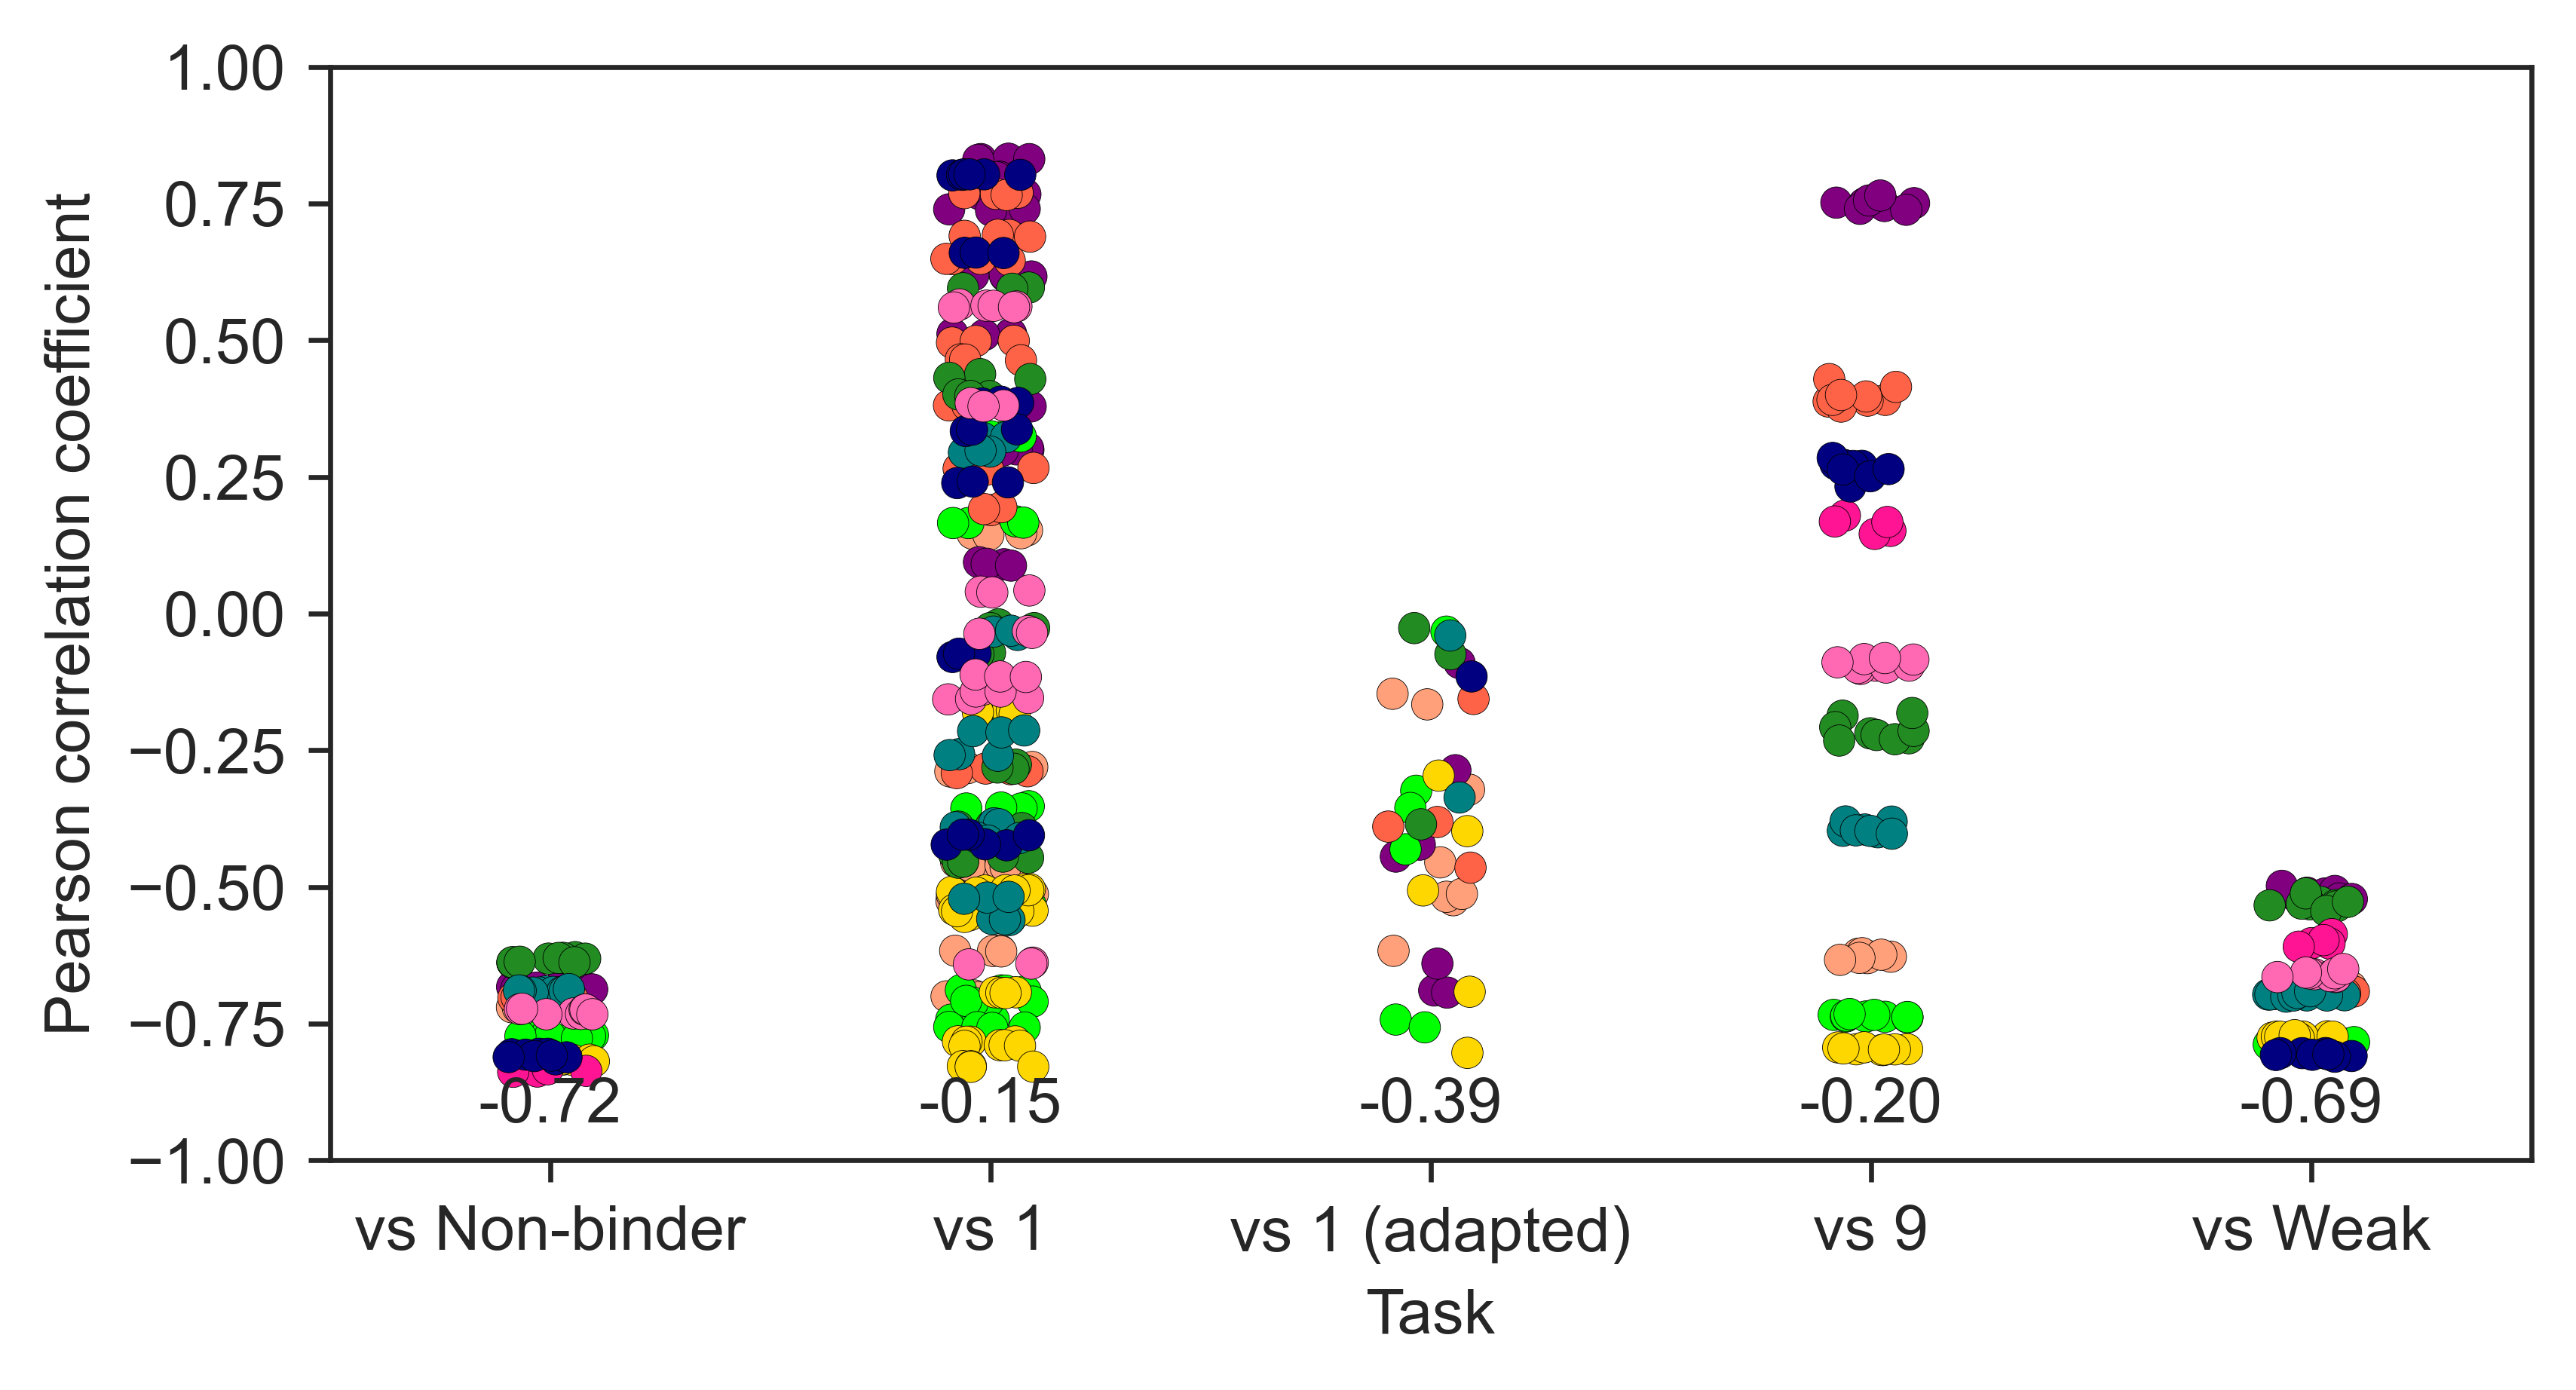

In [20]:
#return here
plt.rcParams['svg.fonttype'] = 'none'
sns.set_style("white")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

palette = {'1FBI': '#008080',
 '3VRL': '#FFA07A',
 '2YPV': '#000080',
 '5E94': '#FFD700',
 '1WEJ': '#228B22',
 '1OB1': '#FF69B4',
 '1NSN': '#800080',
 '1H0D': '#FF6347',
 '3RAJ': '#00FF00',
 '1ADQ': '#FF1493'} 

# task_order = ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]
task_order = ["high_vs_95low", "1v1", "1v1_adapted", "1v9", "high_vs_looser"]

sns.stripplot(
    data=df_attrib, 
    x="task_type", 
    y="mean_pos_total", 
    order=task_order,
    hue="ag_pos",
    ax=ax,
    # cmap=visualisations.PlotParams.cmap_antigens,
    palette=palette,
    edgecolor = 'black',
    linewidth =  0.1
)

ax.legend_.remove()

# Relabel xticks
ax.set_xticklabels(map(lambda x: visualisations.PlotParams.map_task_type_to_clean[x], task_order))

# Add median r_pos per task
r_median_df = df_attrib.groupby(["task_type"]).agg({"mean_pos_total": "median"})
for i, row in r_median_df.iterrows():
    ax.text(
        i,
        -0.93,
        f"{row['mean_pos_total']:.2f}",
        # Center center
        horizontalalignment='center',
    )

# ax.set_title("Mean{Correlation(Energycontribution, Attribution)} for positive class")
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Task")
ax.set_ylim(-1, 1)

# Save fig as .svg
fig.savefig(
    "./figures/S2F_Linear_Attributions-Energy.svg",
    bbox_inches='tight',
    dpi=600,
    transparent=True,
)

In [ ]:
# Anova test that all are different
from scipy.stats import f_oneway
f_oneway(
    df_attrib.query("task_type == 'high_vs_95low'")["mean_pos_total"],
    df_attrib.query("task_type == '1v1'")["mean_pos_total"],
    df_attrib.query("task_type == '1v9'")["mean_pos_total"],
    df_attrib.query("task_type == 'high_vs_looser'")["mean_pos_total"],
)

F_onewayResult(statistic=88.00453735520274, pvalue=2.505759992471136e-46)

In [ ]:
# define_task_col(df_attrib)
# df_attrib_agg = df_attrib.groupby(["task", "task_type"]).agg({"mean_pos_total": "mean"}).reset_index()
# df_contributions_merged = pd.merge(df_acc_agg, df_attrib_agg, on=["task", "task_type"], how='inner')
# df_contributions_merged

NameError: name 'df_acc_agg' is not defined

vs 1
vs 9
vs Non-binder
vs Weak


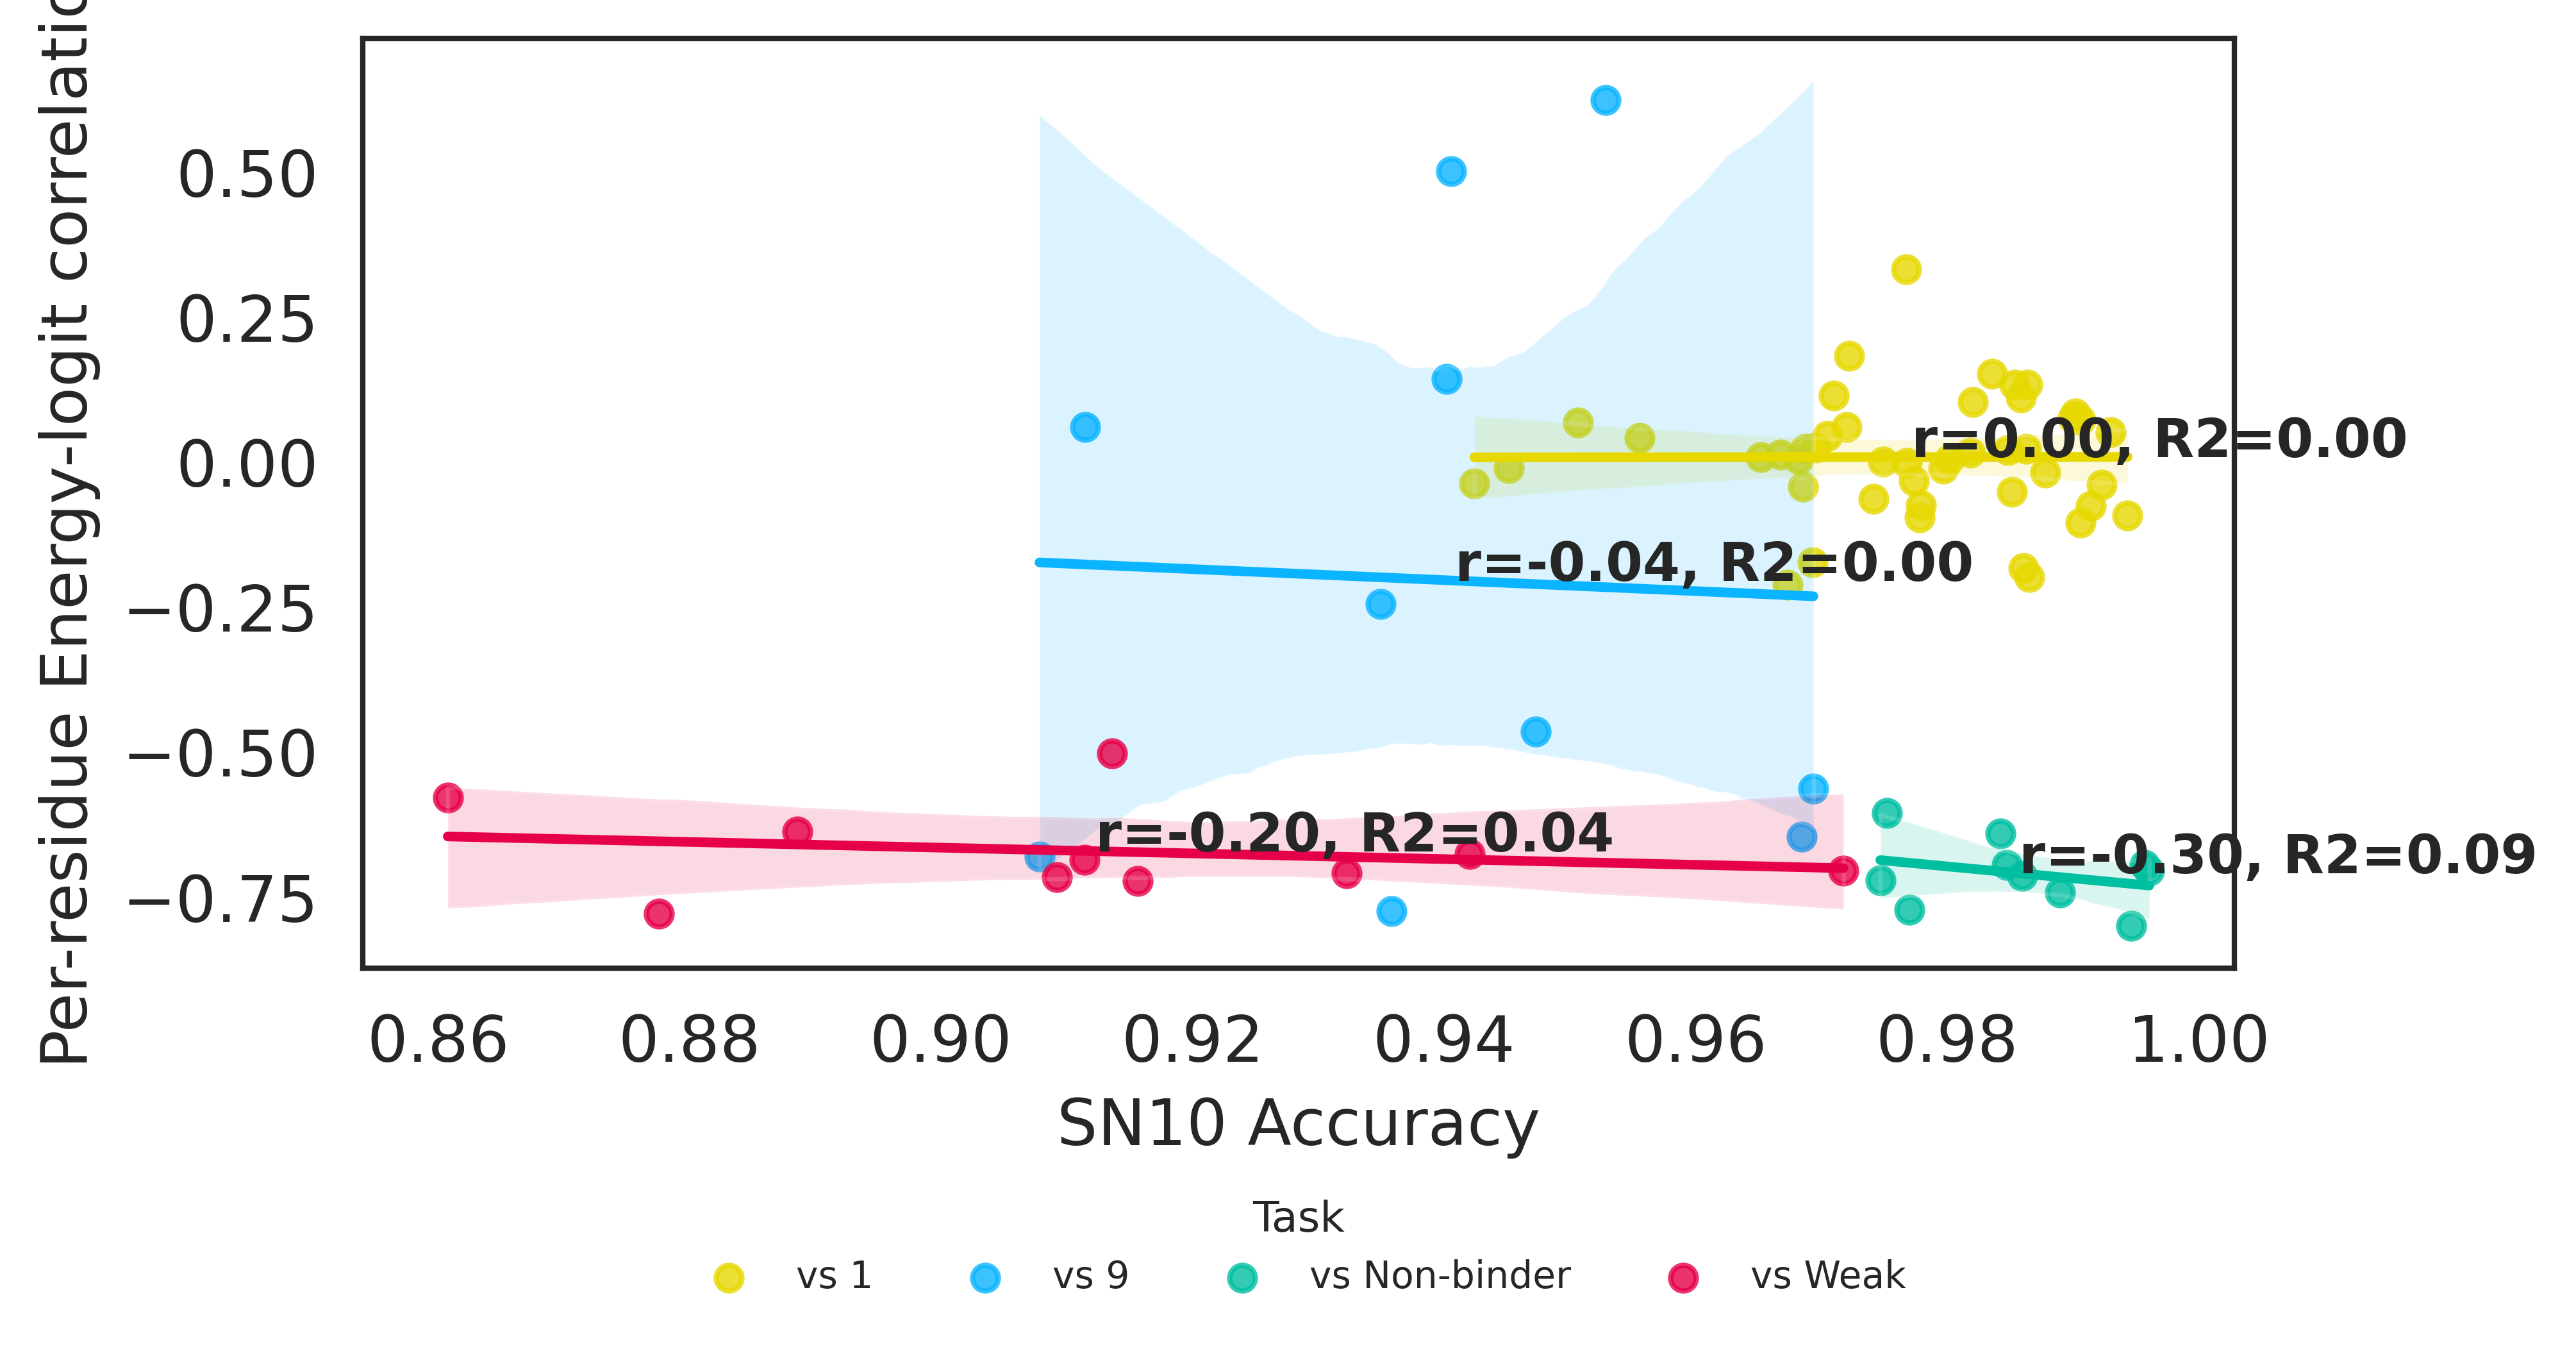

In [ ]:
# from scipy.stats import pearsonr

# cmap = visualisations.PlotParams.cmap_tasks

# sns.set_theme(context="paper")
# sns.set_style("white")
# fig, ax = plt.subplots(figsize=(2*3.14, 3.14), dpi=600)

# # Map to tasks clean
# df_contributions_merged["task_type_clean"] = df_contributions_merged["task_type"].map(visualisations.PlotParams.map_task_type_to_clean)

# # Line plot in seaborn with R2 regression
# for i, df_g in df_contributions_merged.groupby("task_type_clean"):
#     print(i)
#     color = cmap[visualisations.PlotParams.order_tasks_clean.index(i)] # type: ignore
#     sns.regplot(
#         x="acc_closed",
#         y="mean_pos_total",
#         data=df_g,
#         scatter=True,
#         color=color,
#         ax=ax,
#         label=i,
#     )

#     # Compute Pearson correlation
#     r, pval = pearsonr(df_g["mean_pos_total"], df_g["acc_closed"])
#     # Add text with r and R2 at centroid
#     y = df_g["mean_pos_total"].mean()
#     x = df_g["acc_closed"].mean()
#     ax.text(x, y, f"r={r:.2f}, R2={r**2:.2f}", fontsize=10, fontweight="bold")

# FONT_SIZE = 12
# ax.tick_params(labelsize=FONT_SIZE)
# ax.legend(
#     bbox_to_anchor=(0.5, -0.3),
#     loc="center",
#     borderaxespad=0.0,
#     fontsize=7,
#     title="Task",
#     title_fontsize=8,
#     ncol=10,
#     frameon=False,
# )
# ax.set_ylabel("Per-residue Energy-logit correlation", fontsize=FONT_SIZE)
# ax.set_xlabel("SN10 Accuracy", fontsize=FONT_SIZE)

# # ax.set_yticks(yticks)

# # Title
# # ax.set_title("Relationship beteen SN10 accuracy and Jensen-Shannon Divergence (JSD)", fontsize=FONT_SIZE)

# # fig.savefig("figures/1B.svg")
# fig.show()

Plotting individual energy contributions correlations

In [ ]:
def plot_energy_contributions_per_task(task, slide_class = "positive", plot_perc = False, ax = None):
    _, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)
    all_energies = []
    all_energies_perc = []
    all_attrs = []
    all_attrs_perc = []

    for i, row in slide_df.iterrows():
        if row["class"] != slide_class:
            continue
        energies = row["energies"]
        all_energies += energies
        all_energies_perc += (np.array(energies) / np.sum(energies)).tolist()

        attrs = row["attributions"]
        all_attrs += attrs.tolist()
        all_attrs_perc += (np.array(attrs) / np.sum(np.abs(attrs))).tolist()

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    if plot_perc:
        ax.plot(
            all_attrs_perc, 
            all_energies_perc, 
            'o', 
            alpha=0.1,
            color="#f1593a", # red
            )
    else:
        ax.plot(all_attrs, all_energies, 'o', alpha=0.1)

    # Compute correlation and add text

    r, p = pearsonr(all_energies_perc, all_attrs_perc)
    r2 = r ** 2
    ax.text(
        0.23,
        0.03,
        f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
        bbox=dict(facecolor="white", alpha=0.5),
    )

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 vs 9)")

In [ ]:
sns.scatterplot(
    data=df,
    x="Energy",
    y="logits",
    hue="class",
    ax=ax,
    palette=cmap,
)

/tmp/ipykernel_1363179/3403770409.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='Task', ylabel='Pearson correlation coefficient'>

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 0, 'Attribution (signed fraction)')

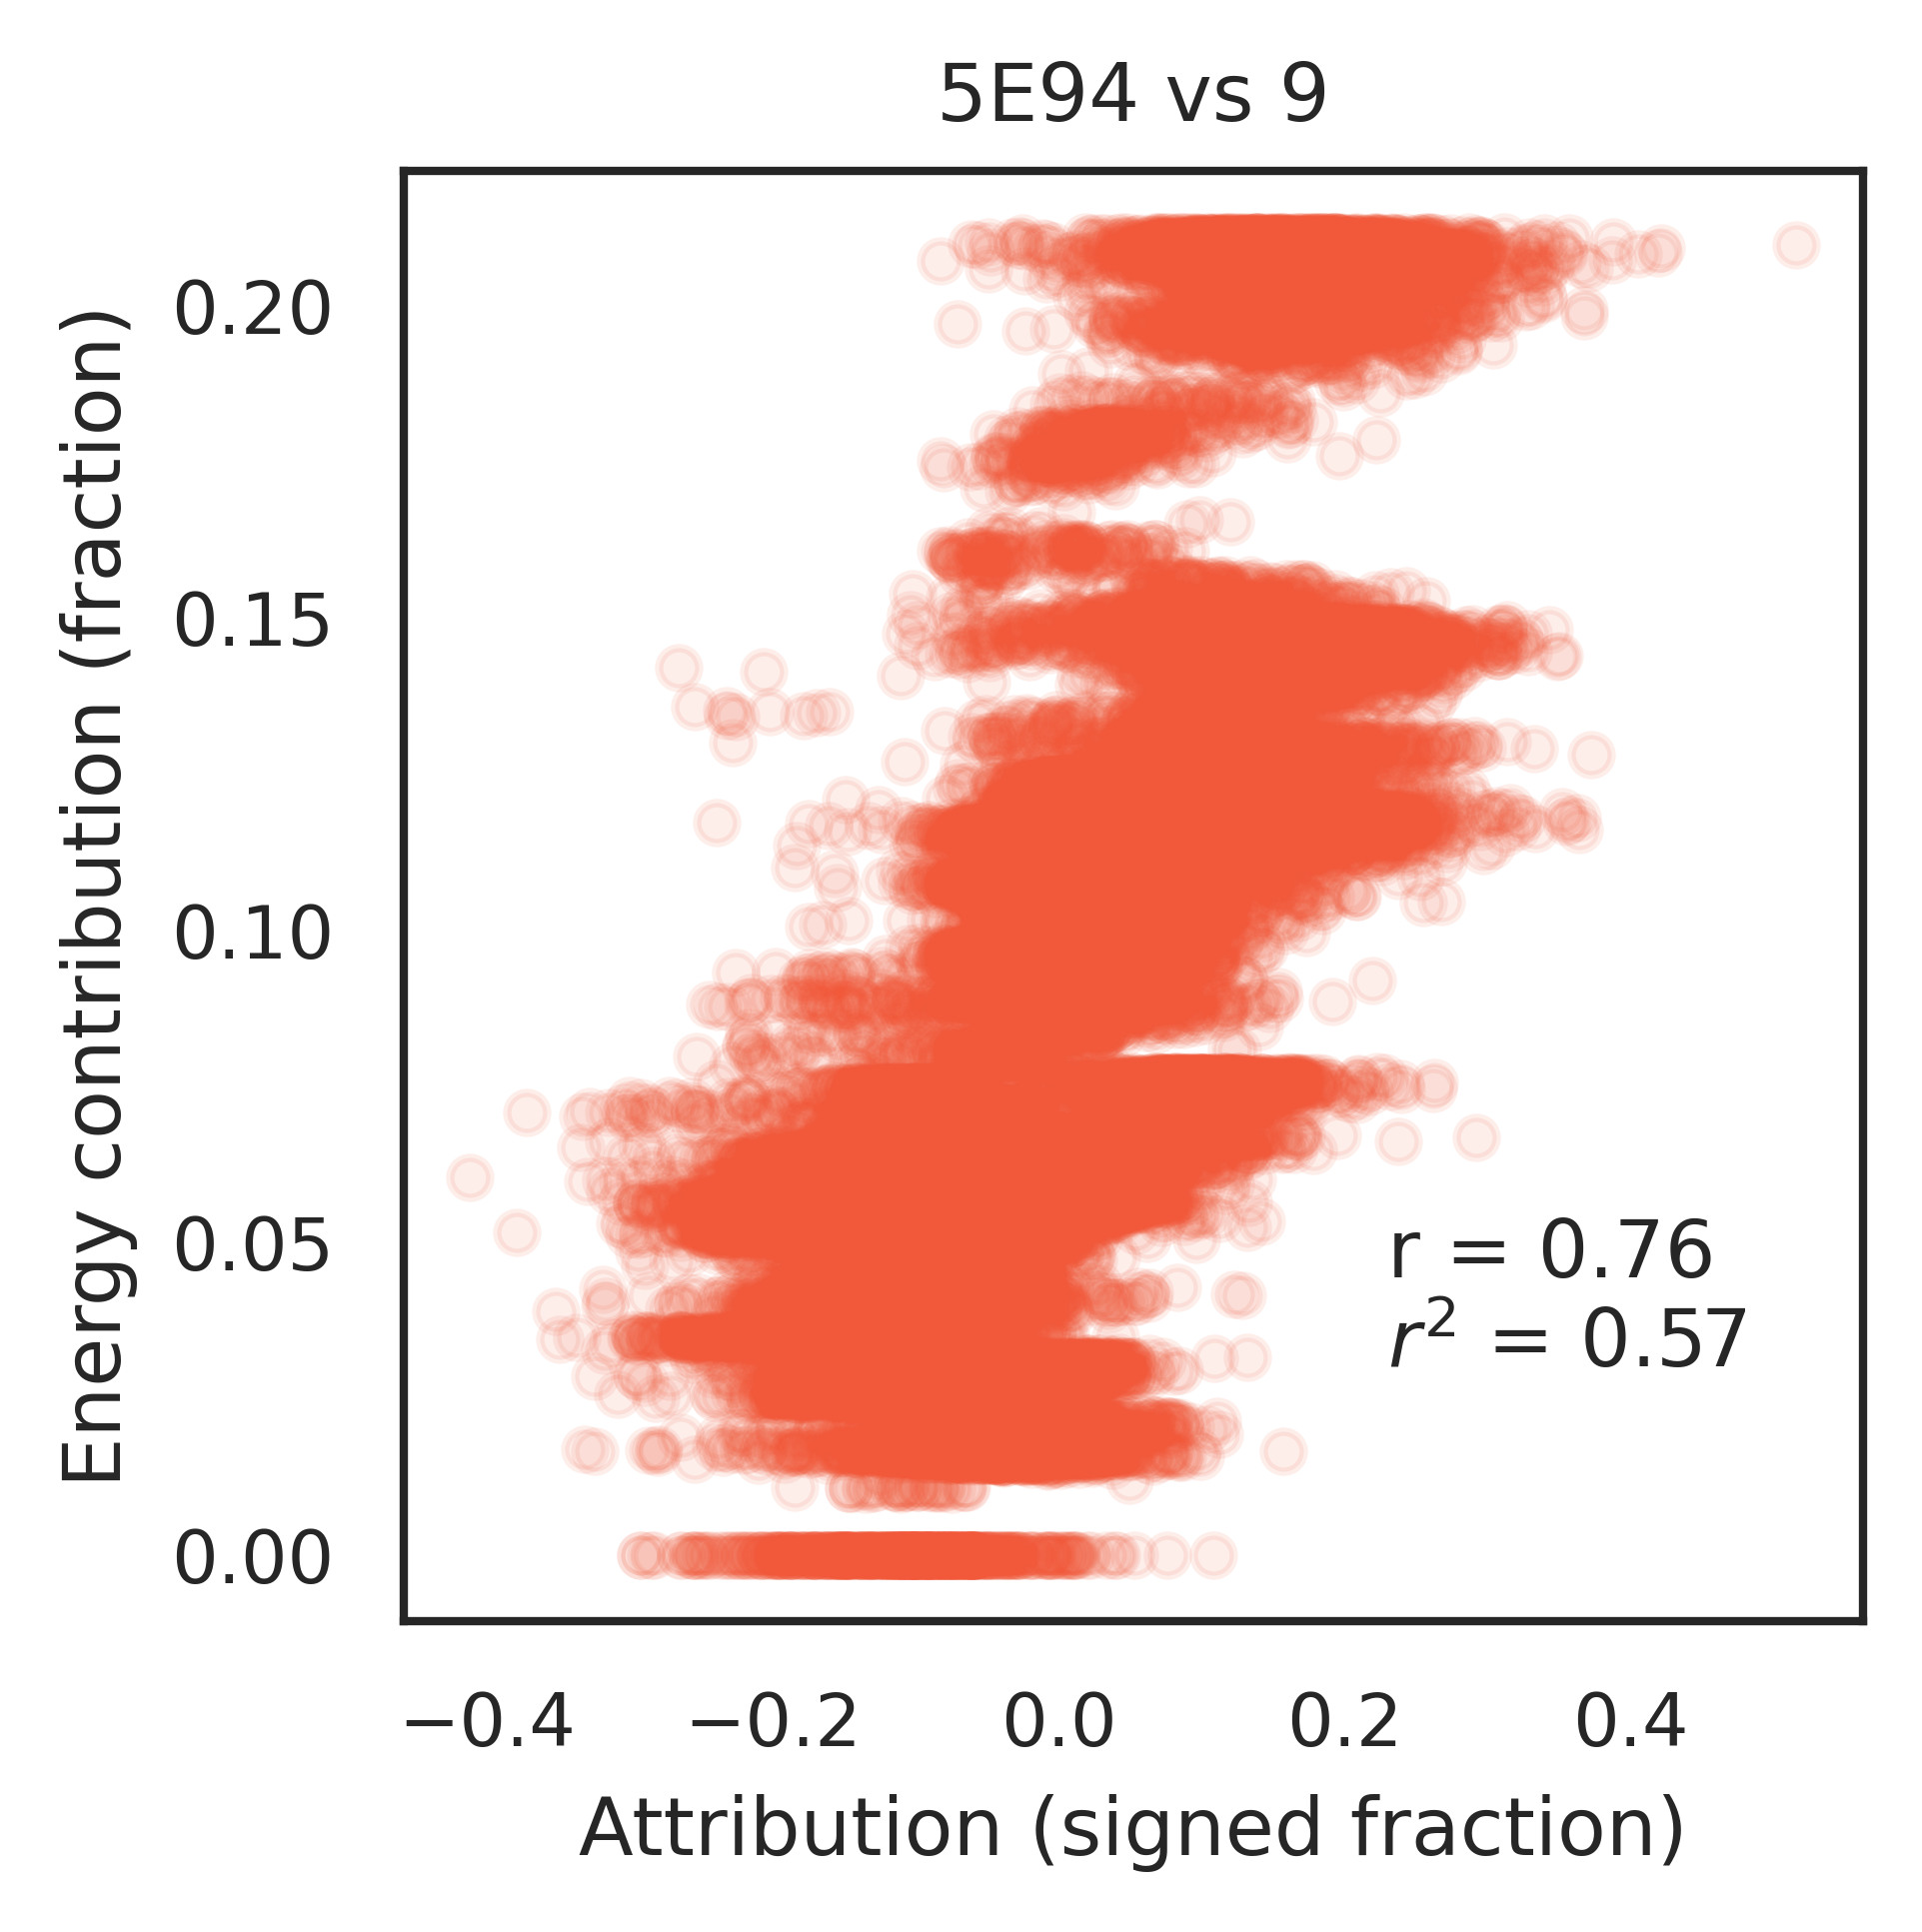

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=0,
)

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

cmap = ["#f1593a"]  # red

plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
ax.set_title("5E94 vs 9")
ax.set_ylabel("Energy contribution (fraction)")
ax.set_xlabel("Attribution (signed fraction)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN vs 9)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="5E94",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (5E94 high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

In [ ]:
# task = datasets.ClassificationTask(
#     task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#     ag_pos="1NSN",
#     ag_neg="auto",
#     seed_id=0,
#     split_id=0,
# )

# fig, ax = plt.subplots(figsize=(10, 5))
# plot_energy_contributions_per_task(task, plot_perc=True, ax=ax)
# ax.set_title("Energy contributions vs attributions for (1NSN high vs looser)")
# ax.set_ylabel("Energy contribution (%)")
# ax.set_xlabel("Attribution (signed %)")

Error analysis on AA Contributions

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="5E94",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


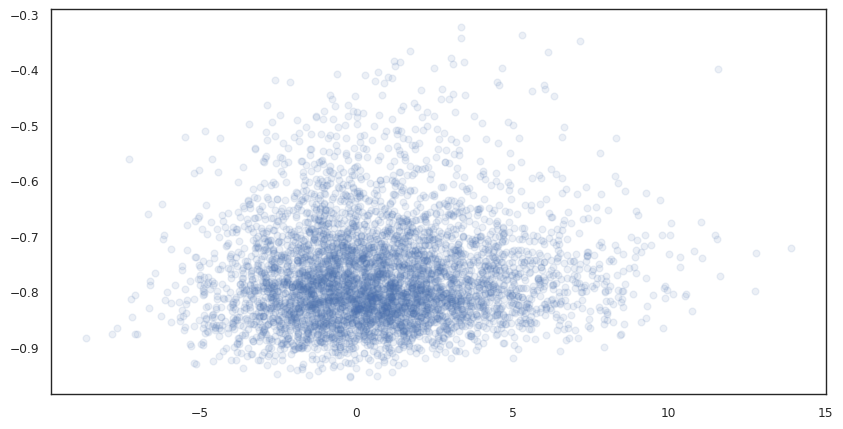

In [ ]:
slide_df["attributions_sum"] = slide_df["attributions"].apply(lambda x: np.sum(x))

# Plot r_total vs attributions_sum
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(slide_df["attributions_sum"], slide_df["r_total"], 'o', alpha=0.1)

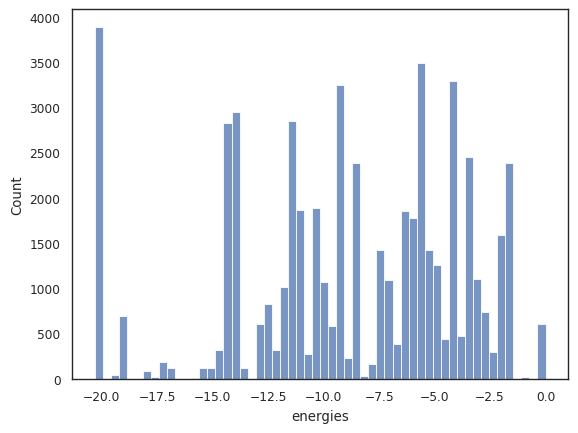

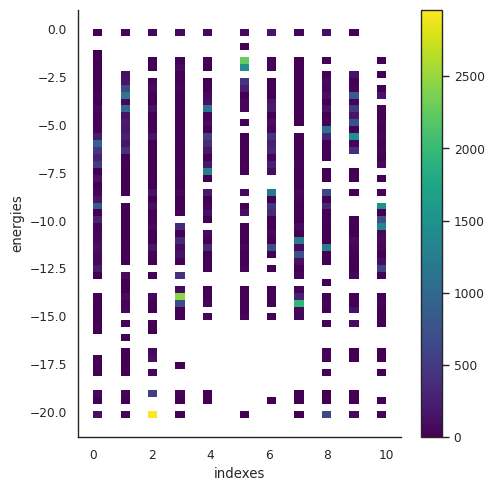

In [ ]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

In [ ]:
task = datasets.ClassificationTask(
    task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
    ag_pos="1NSN",
    ag_neg="auto",
    seed_id=0,
    split_id=42,
)
_, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


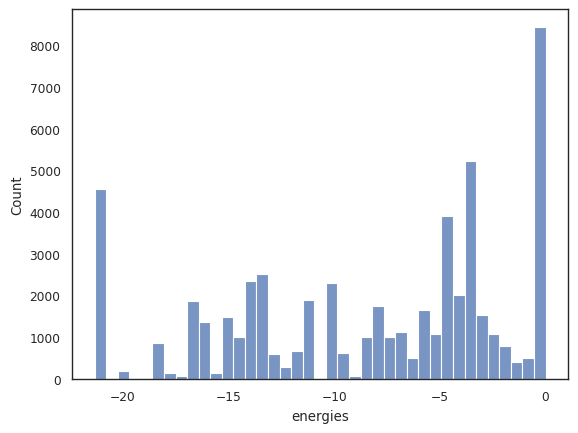

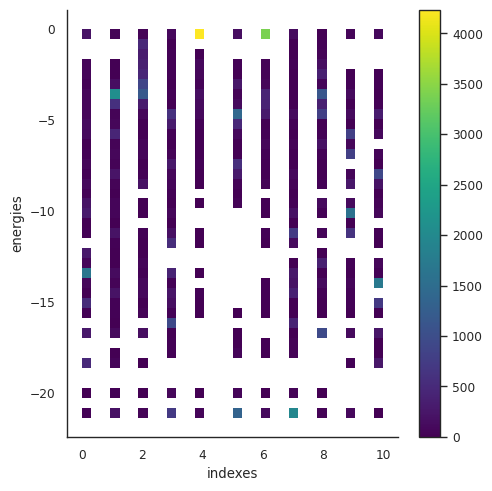

In [ ]:
# Collect all energies with indexes in list from slide_df and plot distribution
energies = []
indexes = []
for i, row in slide_df.iterrows():
    energies_i = row["energies"]
    energies += energies_i
    indexes_i = list(range(0, 11))
    indexes += indexes_i

sns.histplot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="energies",
)

sns.displot(
    data=pd.DataFrame({"energies": energies, "indexes": indexes}),
    x="indexes",
    y="energies",
    cmap="viridis",
    rug=False,
    cbar=True,
)

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/scip

FileNotFoundError: [Errno 2] No such file or directory: '../data/MiniAbsolut/1ADQ/energy_contributions/high_test_5000_absolut_energy_contributions.tsv'

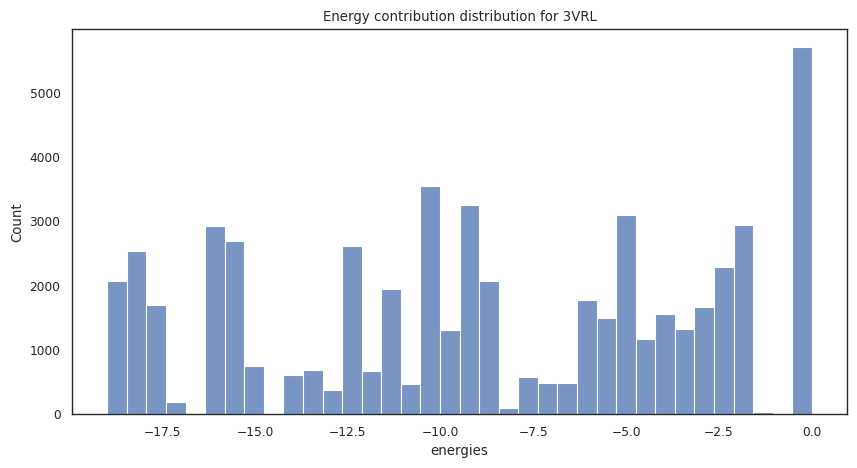

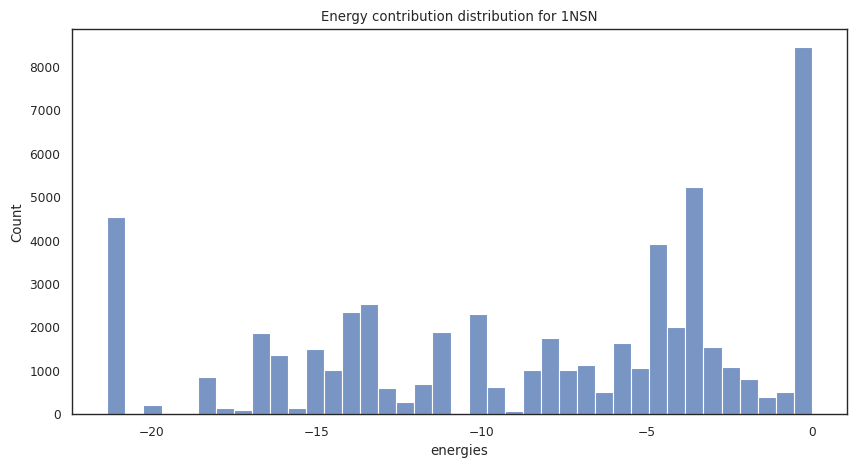

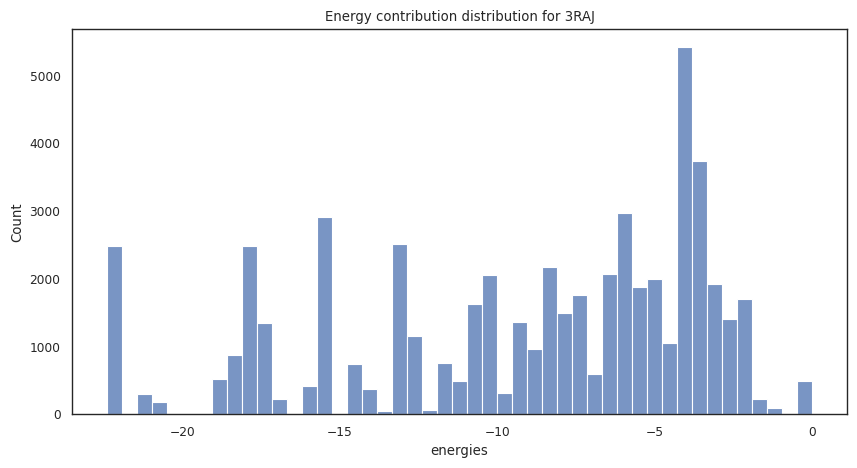

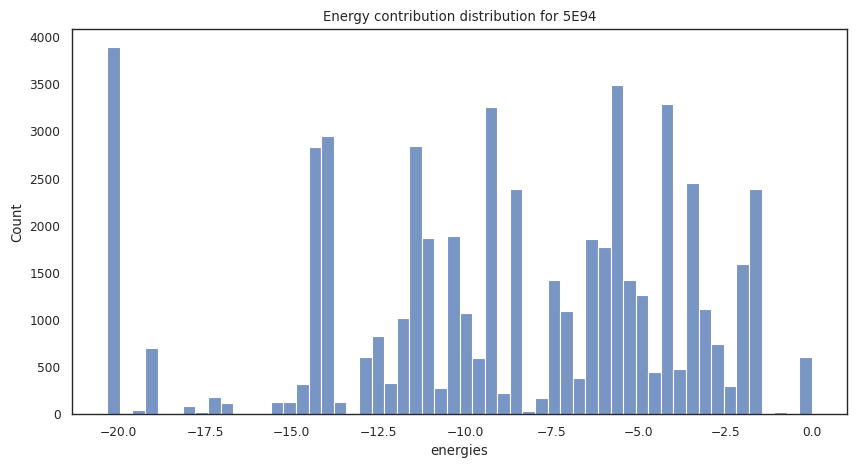

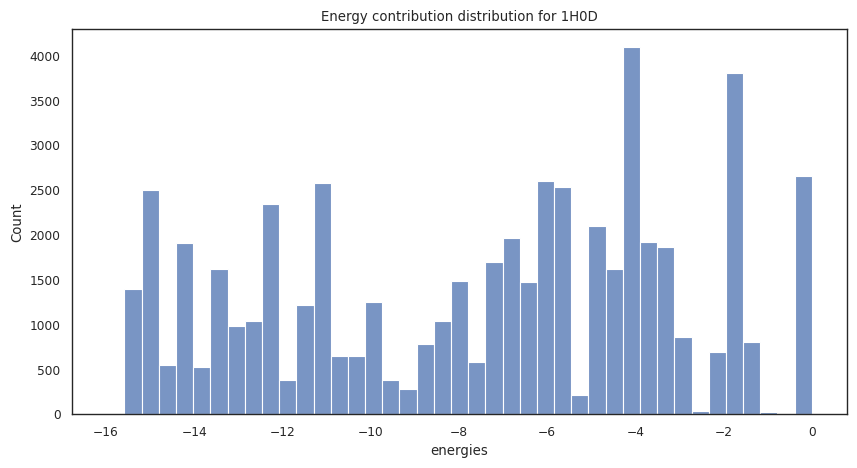

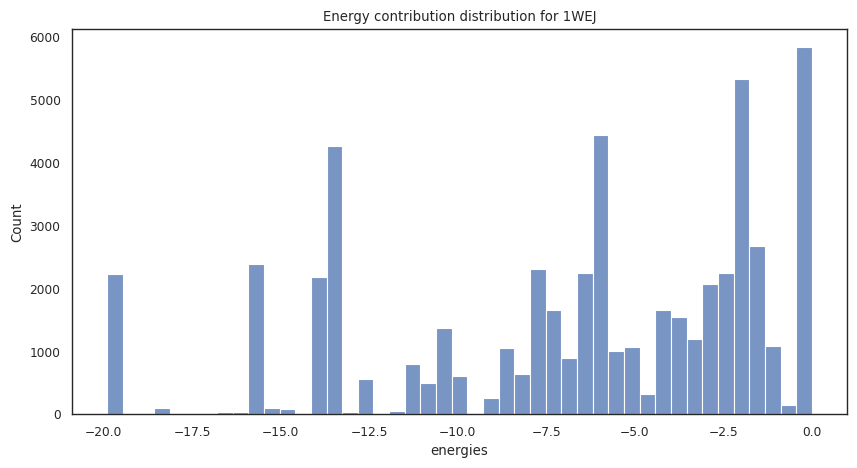

In [ ]:
for ag in config.ANTIGENS:
    task = datasets.ClassificationTask(
        task_type=datasets.ClassificationTaskType.ONE_VS_NINE,
        ag_pos=ag,
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )
    _, slide_df = load_energy_contributions_from_task_linear_version(task, load_slide_df=True)
    
    energies = []
    indexes = []
    for i, row in slide_df.iterrows():
        energies_i = row["energies"]
        energies += energies_i
        indexes_i = list(range(0, 11))
        indexes += indexes_i

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(
        data=pd.DataFrame({"energies": energies, "indexes": indexes}),
        x="energies",
    )
    ax.set_title(f"Energy contribution distribution for {ag}")